
**Forked from** https://www.kaggle.com/orangutan/keras-vgg19-starter

**For details**,.. https://www.kaggle.com/c/dog-breed-identification


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
#from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import cv2
import sys
import bcolz
import random


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


dog-breed-identification
keras-pretrained-models



First we will read in the csv's so we can see some more information on the filenames and breeds

In [2]:
df_train = pd.read_csv('../input/dog-breed-identification/labels.csv')
df_test = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

In [3]:
df_train.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
train_files = glob('../input/dog-breed-identification/train/*.jpg')
test_files = glob('../input/dog-breed-identification/test/*.jpg')



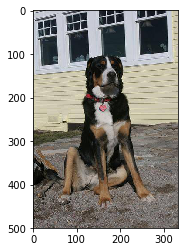

In [6]:
plt.imshow(plt.imread(train_files[100]))

In [7]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [8]:
!ls ../input/keras-pretrained-models/

Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


Next we will read in all of the images for test and train, using a for loop through the values of the csv files. I have also set an im_size variable which sets the size for the image to be re-sized to,  90x90 px, you should play with this number to see how it affects accuracy.

In [9]:
im_size = 224

In [10]:
y_train = []
y_val = []
x_train_raw = bcolz.zeros((0,im_size,im_size,3),np.float32)
x_val_raw = bcolz.zeros((0,im_size,im_size,3),np.float32)

In [11]:
i = 0 
for f, breed in tqdm(df_train.values):
    # load an image from file
    image = load_img('../input/dog-breed-identification/train/{}.jpg'.format(f), target_size=(im_size, im_size))
    image = img_to_array(image)
    # prepare the image for the VGG model
    #image = preprocess_input(image)
    label = one_hot_labels[i]
    if random.randint(1,101) < 80: 
        x_train_raw.append(image)
        y_train.append(label)
    else:
        x_val_raw.append(image)
        y_val.append(label)
    i += 1

100%|██████████| 10222/10222 [00:57<00:00, 177.38it/s]


In [12]:
y_train_raw = np.array(y_train, np.uint8)
y_val_raw = np.array(y_val, np.uint8)
del(y_train,y_val)
import gc
gc.collect()

15

We check the shape of the outputs to make sure everyting went as expected.

In [13]:
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_val_raw.shape)
print(y_val_raw.shape)

(7977, 224, 224, 3)
(7977, 120)
(2245, 224, 224, 3)
(2245, 120)


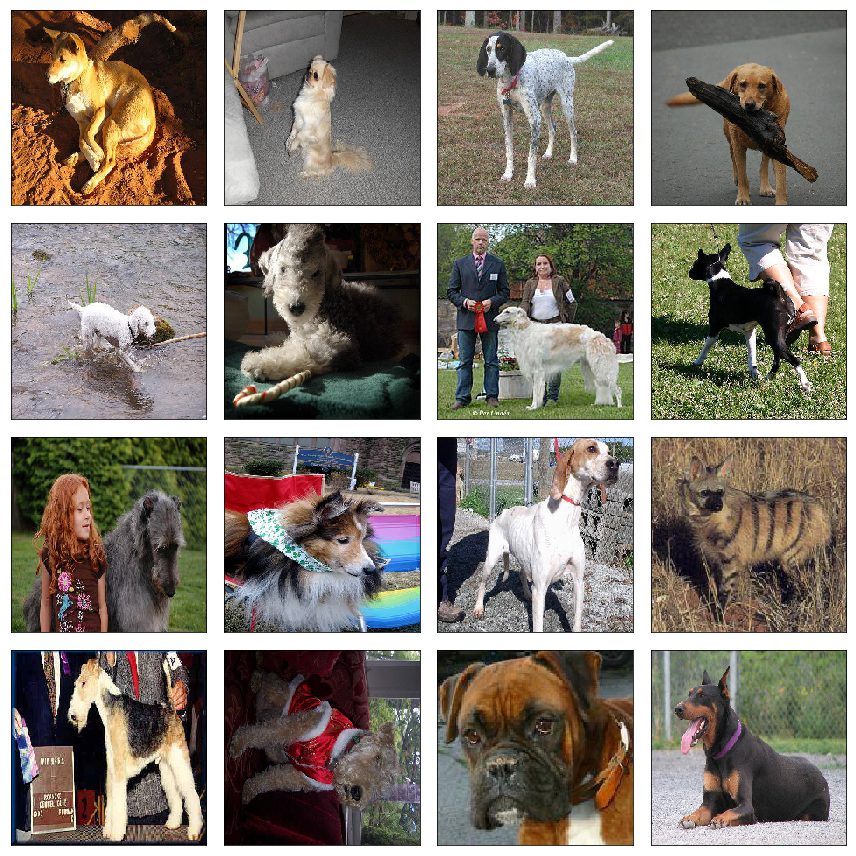

In [14]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
plotImages(x_train_raw[0:16,]/255.)

In [15]:
num_class = y_train_raw.shape[1]

In [16]:
# Create the base pre-trained model
base_model = VGG19(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
#base_model = ResNet50(weights = 'imagenet', include_top=False, input_shape=(im_size, im_size, 3))
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____

In [17]:
len(base_model.layers)

22

In [18]:
layers_to_remove = 0
if layers_to_remove >0:
    for i in range(0,layers_to_remove):
        base_model.layers.pop()
    base_model.summary()

In [19]:
fine_tuning_layers = 0
layers_to_freeze = len(base_model.layers) - fine_tuning_layers
print(layers_to_freeze)

for layer in base_model.layers[0:layers_to_freeze]:
    layer.trainable = False

22


In [20]:
# Add a new top layer
x = base_model.layers[layers_to_freeze-1+fine_tuning_layers].output
x = GlobalAveragePooling2D()(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=x)

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, im_size = 224, batch_size=32, shuffle=True, data_augment = False, test = False):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = np.arange(0,data.shape[0])
        self.shuffle = shuffle
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)        
        self.data = data
        self.data_augment = data_augment
        self.test = test
        if self.test == False:
            self.labels = labels
        self.on_epoch_end()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.list_IDs[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        if self.test == False:
            X, y = self.__data_generation(indexes)
            return preprocess_input(X), y
        else:
            X = self.__data_generation(indexes)
            return preprocess_input(X)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)        

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((list_IDs_temp.shape[0],im_size,im_size,3), dtype=np.float32)
        if self.test == False:
            y = np.zeros((list_IDs_temp.shape[0],self.labels.shape[1]), dtype=np.uint8)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            if self.data_augment == True:
                if random.randint(1,101) < 50: 
                    flip_horizontal = True
                else:
                    flip_horizontal = False
                if random.randint(1,101) < 50: 
                    flip_vertical = True
                else:
                    flip_vertical = False
                tx = im_size*random.randint(1,2)/100.0
                ty = im_size*random.randint(1,2)/100.0
                shear = random.randint(1,10)/100.0
                zx = random.randint(80,120)/100.0
                zy = random.randint(80,120)/100.0
                brightness = random.randint(1,2)/100.0
                channel_shift_intensity = random.randint(1,10)/100.0
                
                X[i,] = self.data[ID,]
            else:
                # Store sample
                X[i,] = self.data[ID,]

            # Store class
            if self.test == False:
                y[i,] = self.labels[ID,]

        if self.test == False:
            return X, y
        else:
            return X

In [22]:
batch_size = 1

# Parameters
params_trn = {
          'im_size': im_size,
          'batch_size': batch_size,
          'shuffle': False,
          'data_augment' : True,
          'test' : False
         }
params_val = {
          'im_size': im_size,
          'batch_size': batch_size,
          'shuffle': False,
          'data_augment' : False,
          'test' : False
         }

# Generators
training_generator = DataGenerator(x_train_raw, y_train_raw, **params_trn)
validation_generator = DataGenerator(x_val_raw, y_val_raw, **params_val)

In [23]:
preds_trn = model.predict_generator(training_generator, steps = int(x_train_raw.shape[0]), verbose=1)
preds_val = model.predict_generator(validation_generator, steps = int(x_val_raw.shape[0]), verbose=1)

2245/2245 [==============================] - 17s 8ms/step


In [24]:
preds_trn.shape, preds_val.shape,y_train_raw.shape, y_val_raw.shape


((7977, 512), (2245, 512), (7977, 120), (2245, 120))

In [25]:
sub = pd.DataFrame(preds_trn)
sub.to_csv("preds_trn.csv",index =False)
sub = pd.DataFrame(y_train_raw)
sub.to_csv("labels_trn.csv",index =False)

sub = pd.DataFrame(preds_val)
sub.to_csv("preds_val.csv",index =False)
sub = pd.DataFrame(y_val_raw)
sub.to_csv("labels_val.csv",index =False)



In [26]:
# creating a single lable column with 0 to 119 based on the location of 1.


trn_DV = np.array(np.where(y_train_raw==1)[1])
val_DV = np.array(np.where(y_val_raw==1)[1])

trn_DV.shape,val_DV.shape
# len(set(trn_DV))

((7977,), (2245,))

In [27]:
meta_trn_preds = pd.DataFrame(preds_trn).describe(include='all').T
meta_trn_preds.head(5)


,count,mean,std,min,25%,50%,75%,max
0,7977.0,2.748585,2.863819,0.0,0.628184,1.884266,3.962421,25.177954
1,7977.0,1.675818,2.495262,0.0,0.000000,0.599001,2.325276,23.521200
2,7977.0,5.087391,5.943683,0.0,0.881123,2.956335,7.273804,51.410347
3,7977.0,0.375156,1.043407,0.0,0.000000,0.000000,0.256592,24.120331
4,7977.0,10.029089,9.829618,0.0,2.934352,7.006656,13.915510,70.951698


In [28]:
meta_trn_labl = pd.DataFrame(trn_DV).describe().T
meta_trn_labl.head(5)

,count,mean,std,min,25%,50%,75%,max
0,7977.0,59.299486,34.774134,0.0,29.0,60.0,89.0,119.0


In [29]:
meta_val_preds = pd.DataFrame(preds_val).describe(include='all').T
meta_val_preds.head(5)

,count,mean,std,min,25%,50%,75%,max
0,2245.0,2.679412,2.788137,0.0,0.621414,1.865390,3.892086,19.743458
1,2245.0,1.668567,2.581632,0.0,0.000000,0.534181,2.324610,21.823301
2,2245.0,5.304979,6.061190,0.0,1.081446,3.256058,7.404871,43.699528
3,2245.0,0.352939,0.938443,0.0,0.000000,0.000000,0.237132,9.666381
4,2245.0,10.496616,10.140895,0.0,3.079823,7.363108,14.935167,62.792027


In [30]:
meta_val_labl = pd.DataFrame(val_DV).describe(include='all').T
meta_val_labl.head(5)

,count,mean,std,min,25%,50%,75%,max
0,2245.0,59.758129,35.080171,0.0,28.0,61.0,90.0,119.0


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [32]:
clf = LogisticRegression(random_state=1, multi_class='multinomial', solver='saga',max_iter = 2000,verbose=1)
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=1, solver='saga',
          tol=0.0001, verbose=1, warm_start=False)

In [33]:
log_model = clf.fit(preds_trn,trn_DV)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 1373 epochs took 3024 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 50.4min finished


In [34]:
parameters = log_model.coef_
parameters.size

61440

In [35]:
# log_model.classes_

len(set(log_model.predict(preds_val)))

120

In [36]:
import pickle
filename = 'log_model.sav'
# pickle.dump(log_model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [37]:
print("Log loss is: ", log_loss(val_DV, pd.DataFrame(log_model.predict_proba(preds_val))))
print("Accuracy is: ", accuracy_score(val_DV, pd.DataFrame(log_model.predict(preds_val))))

Log loss is:  1.4831862155417257
Accuracy is:  0.6975501113585746


In [38]:
# del(meta_trn_preds,meta_trn_labl)
# import gc
# gc.collect()

In [39]:
# x_test = []
x_test = bcolz.zeros((0,im_size,im_size,3),np.float32)
# x_train_raw = bcolz.zeros((0,im_size,im_size,3),np.float32)
for f in tqdm(df_test['id'].values):
    img = cv2.imread('../input/dog-breed-identification/test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (im_size, im_size)))
x_test  = np.array(x_test, np.float32) / 255.
print(x_test.shape)

100%|██████████| 10357/10357 [01:03<00:00, 162.76it/s]


MemoryError: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

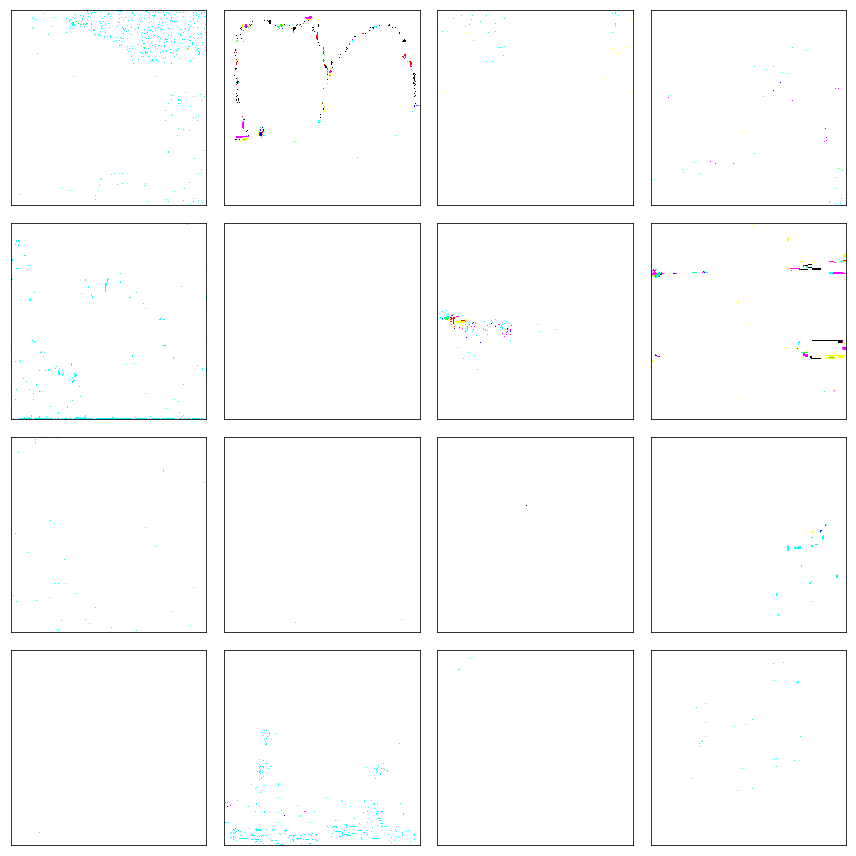

In [40]:
plotImages(x_test[0:16,])

In [41]:
params_test = {
          'im_size': im_size,
          'batch_size': batch_size,
          'shuffle': False,
          'data_augment' : False,
          'test' : True
         }

# Generators
# y_test = []
y_test = bcolz.zeros((0,im_size,im_size,3),np.float32)
test_generator = DataGenerator(x_test,y_test,**params_test)

In [42]:
preds_test = model.predict_generator(test_generator, steps = int(x_test.shape[0]), verbose=1)

10357/10357 [==============================] - 79s 8ms/step


In [43]:
pd.DataFrame(preds_test).describe().T.head(5)

,count,mean,std,min,25%,50%,75%,max
0,10357.0,1.424557,1.837686,0.0,0.137482,0.785528,1.980057,20.234488
1,10357.0,1.310361,2.131082,0.0,0.000000,0.342808,1.732407,19.528572
2,10357.0,3.419200,4.132231,0.0,0.558129,1.955249,4.797657,34.154453
3,10357.0,0.389589,1.067237,0.0,0.000000,0.000000,0.283693,27.456358
4,10357.0,8.351791,8.354548,0.0,2.239064,5.710994,11.818933,81.104897


In [44]:
preds = log_model.predict(preds_test)
len(set(preds))

120

In [45]:
pd.DataFrame(preds+1).describe()

,0
count,10357.000000
mean,66.181327
std,34.719598
min,1.000000
25%,38.000000
50%,67.000000
75%,98.000000
max,120.000000


In [46]:
sub = pd.DataFrame(pd.get_dummies(preds+1,drop_first=False))
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns.size,col_names.shape
# Insert the column id from the sample_submission at the start of the data frame
# sub.insert(0, 'id', df_test['id'])
# sub.head(5)
# 

(120, (120,))

In [47]:
len(set(preds))

120

In [48]:
sub_dum = pd.get_dummies(preds)
sub_dum[sub_dum.sum(axis=1)==0].shape

(0, 120)